# Config

## Library

In [1]:
import pickle as pickle
import os
from functools import partial
from typing import Tuple, List, Any, Dict
import random
import pandas as pd
import torch
import sklearn
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, Trainer, TrainingArguments, RobertaConfig, RobertaTokenizer, RobertaForSequenceClassification, BertTokenizer
from metrics import *
from load_data import *

## Settings

In [2]:
##----------------
def set_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # for faster training, but not deterministic

set_seeds()    

KLUE에서 제시된 hyperparameter setting 

### Fine-tuning

In [3]:
# Search space
tune_config = {
    "per_device_train_batch_size": tune.choice([8, 16, 32]),
    "per_device_eval_batch_size": 32,
    "learning_rate": tune.choice([1e-5, 2e-5, 3e-5, 5e-5]),
    "warmup_ratio": tune.choice([0., 0.1, 0.2, 0.6]),
    "weihgt_decay": tune.choice([0.0, 0.01]),
    "num_train_epochs": tune.choice([3, 4, 5, 10]),
}

NameError: name 'tune' is not defined

In [5]:
# patience = 10000
output_dir = "klue_dir"
wandb_project = "klue_re_klue-baseline[fp16]"
run_name = "roberta-large"
report_to = "wandb"
max_length = 128

# Data

In [6]:
class_names = ['no_relation', 'org:top_members/employees', 'org:members',
       'org:product', 'per:title', 'org:alternate_names',
       'per:employee_of', 'org:place_of_headquarters', 'per:product',
       'org:number_of_employees/members', 'per:children',
       'per:place_of_residence', 'per:alternate_names',
       'per:other_family', 'per:colleagues', 'per:origin', 'per:siblings',
       'per:spouse', 'org:founded', 'org:political/religious_affiliation',
       'org:member_of', 'per:parents', 'org:dissolved',
       'per:schools_attended', 'per:date_of_death', 'per:date_of_birth',
       'per:place_of_birth', 'per:place_of_death', 'org:founded_by',
       'per:religion']

id2label = {idx: label for idx, label in enumerate(class_names)}
label2id = {label: idx for idx, label in enumerate(class_names)}

In [7]:
dataset = pd.read_csv("../dataset/train/train.csv")
label = label_to_num(dataset['label'].values)

In [8]:
dataset['id'] = dataset['id'].astype(str)

In [9]:
dataset['subject_entity'] = dataset['subject_entity'].apply(lambda x : eval(x))
dataset['object_entity'] = dataset['object_entity'].apply(lambda x : eval(x))

In [10]:
dataset['label'] = dataset['label'].map(label2id)

In [11]:
with open('train_eval_idx.pkl', 'rb') as f:
    train_eval_idx = pickle.load(f)

In [12]:
train_dataset = dataset.iloc[train_eval_idx['train']]
dev_dataset = dataset.iloc[train_eval_idx['eval']]

train_label = np.array(label)[train_eval_idx['train']]
dev_label = np.array(label)[train_eval_idx['eval']]

In [13]:
from datasets import Dataset, DatasetDict, Features, Value, ClassLabel
class_labels = ClassLabel(num_classes=30, names=class_names)

In [14]:
hf_train_dataset = Dataset.from_pandas(train_dataset)
hf_dev_dataset = Dataset.from_pandas(dev_dataset)

In [15]:
hf_train_dataset = hf_train_dataset.remove_columns('__index_level_0__')
hf_dev_dataset = hf_dev_dataset.remove_columns('__index_level_0__')

In [16]:
klue_re = DatasetDict({'train' : hf_train_dataset, 'dev' : hf_dev_dataset})

In [17]:
klue_re['train'][0]

{'id': '10706',
 'sentence': '추승우(秋承佑, 1979년 9월 24일 ~)는 전 KBO 리그 한화 이글스의 외야수이자, 현재 KBO 리그 한화 이글스의 작전·주루 및 외야수 수비 코치이다.',
 'subject_entity': {'end_idx': 2,
  'start_idx': 0,
  'type': 'PER',
  'word': '추승우'},
 'object_entity': {'end_idx': 78,
  'start_idx': 76,
  'type': 'POH',
  'word': '외야수'},
 'label': 0,
 'source': 'wikipedia'}

In [18]:
klue_re['train'].features['label'] = ClassLabel(num_classes=30, names=class_names)
klue_re['dev'].features['label'] = ClassLabel(num_classes=30, names=class_names)

In [19]:
klue_re['train'].features

{'id': Value(dtype='string', id=None),
 'sentence': Value(dtype='string', id=None),
 'subject_entity': {'end_idx': Value(dtype='int64', id=None),
  'start_idx': Value(dtype='int64', id=None),
  'type': Value(dtype='string', id=None),
  'word': Value(dtype='string', id=None)},
 'object_entity': {'end_idx': Value(dtype='int64', id=None),
  'start_idx': Value(dtype='int64', id=None),
  'type': Value(dtype='string', id=None),
  'word': Value(dtype='string', id=None)},
 'label': ClassLabel(num_classes=30, names=['no_relation', 'org:top_members/employees', 'org:members', 'org:product', 'per:title', 'org:alternate_names', 'per:employee_of', 'org:place_of_headquarters', 'per:product', 'org:number_of_employees/members', 'per:children', 'per:place_of_residence', 'per:alternate_names', 'per:other_family', 'per:colleagues', 'per:origin', 'per:siblings', 'per:spouse', 'org:founded', 'org:political/religious_affiliation', 'org:member_of', 'per:parents', 'org:dissolved', 'per:schools_attended', 'per:

In [20]:
hf_train_dataset[0]

{'id': '10706',
 'sentence': '추승우(秋承佑, 1979년 9월 24일 ~)는 전 KBO 리그 한화 이글스의 외야수이자, 현재 KBO 리그 한화 이글스의 작전·주루 및 외야수 수비 코치이다.',
 'subject_entity': {'end_idx': 2,
  'start_idx': 0,
  'type': 'PER',
  'word': '추승우'},
 'object_entity': {'end_idx': 78,
  'start_idx': 76,
  'type': 'POH',
  'word': '외야수'},
 'label': 0,
 'source': 'wikipedia'}

In [21]:
# tokenizing dataset
MODEL_NAME = "klue/roberta-large"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/opt/conda/envs/basic/lib/python3.8/site-packages/transformers/configuration_utils.py:336: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [22]:
markers = dict(
    subject_start_marker="<subj>",
    subject_end_marker="</subj>",
    object_start_marker="<obj>",
    object_end_marker="</obj>",
)

In [23]:
# create_example
def mark_entity_spans(examples,
                      subject_start_marker: str, subject_end_marker: str,
                      object_start_marker: str, object_end_marker: str):

    def _mark_entity_spans(
        text: str, 
        subject_range=Tuple[int, int], 
        object_range=Tuple[int, int]
    ) -> str:
        """ Adds entity markers to the text to identify the subject/object entities.
        Args:
            text: Original sentence
            subject_range: Pair of start and end indices of subject entity
            object_range: Pair of start and end indices of object entity
        Returns:
            A string of text with subject/object entity markers
        """
        if subject_range < object_range:
            segments = [
                text[: subject_range[0]],
                subject_start_marker,
                text[subject_range[0] : subject_range[1] + 1],
                subject_end_marker,
                text[subject_range[1] + 1 : object_range[0]],
                object_start_marker,
                text[object_range[0] : object_range[1] + 1],
                object_end_marker,
                text[object_range[1] + 1 :],
            ]
        elif subject_range > object_range:
            segments = [
                text[: object_range[0]],
                object_start_marker,
                text[object_range[0] : object_range[1] + 1],
                object_end_marker,
                text[object_range[1] + 1 : subject_range[0]],
                subject_start_marker,
                text[subject_range[0] : subject_range[1] + 1],
                subject_end_marker,
                text[subject_range[1] + 1 :],
            ]
        else:
            raise ValueError("Entity boundaries overlap.")

        marked_text = "".join(segments)

        return marked_text
    
    subject_entity = examples["subject_entity"]
    object_entity = examples["object_entity"]
    
    text = _mark_entity_spans(
        examples["sentence"],
        (subject_entity["start_idx"], subject_entity["end_idx"]),
        (object_entity["start_idx"], object_entity["end_idx"]),
    )
    return {"text": text}

mark_entity_spans = partial(mark_entity_spans, **markers)

In [24]:
examples = klue_re.map(mark_entity_spans)

  0%|          | 0/25976 [00:00<?, ?ex/s]

  0%|          | 0/6494 [00:00<?, ?ex/s]

In [25]:
examples

DatasetDict({
    train: Dataset({
        features: ['id', 'sentence', 'subject_entity', 'object_entity', 'label', 'source', 'text'],
        num_rows: 25976
    })
    dev: Dataset({
        features: ['id', 'sentence', 'subject_entity', 'object_entity', 'label', 'source', 'text'],
        num_rows: 6494
    })
})

In [26]:
tokenizer.add_special_tokens(
    {"additional_special_tokens": list(markers.values())}
)

4

In [27]:
def convert_example_to_features(
    examples, 
    tokenizer,
    subject_start_marker: str,
    subject_end_marker: str,
    object_start_marker: str,
    object_end_marker: str
) -> Dict[str, List[Any]]:
    
    def fix_tokenization_error(text: str) -> List[str]:
        """Fix the tokenization due to the `obj` and `subj` marker inserted
        in the middle of a word.
        Example:
            >>> text = "<obj>조지 해리슨</obj>이 쓰고 <subj>비틀즈</subj>가"
            >>> tokens = ['<obj>', '조지', '해리', '##슨', '</obj>', '이', '쓰', '##고', '<subj>', '비틀즈', '</subj>', '가']
            >>> fix_tokenization_error(text)
            ['<obj>', '조지', '해리', '##슨', '</obj>', '##이', '쓰', '##고', '<subj>', '비틀즈', '</subj>', '##가']
            
        Only support for BertTokenizerFast
        If you use bbpe, change code!
        """
        batch_encoding = tokenizer._tokenizer.encode(text)
        tokens = batch_encoding.tokens
        # subject
        if text[text.find(subject_end_marker) + len(subject_end_marker)] != " ":
            space_idx = tokens.index(subject_end_marker) + 1
            # tokenizer_type == "bert-wp"
            if not tokens[space_idx].startswith("##") and "가" <= tokens[space_idx][0] <= "힣":
                tokens[space_idx] = "##" + tokens[space_idx]

        # object
        if text[text.find(object_end_marker) + len(object_end_marker)] != " ":
            space_idx = tokens.index(object_end_marker) + 1
            # tokenizer_type == "bert-wp"
            if not tokens[space_idx].startswith("##") and "가" <= tokens[space_idx][0] <= "힣":
                tokens[space_idx] = "##" + tokens[space_idx]
        
        return tokens    
    
    tokens = fix_tokenization_error(examples["text"])
    
    return {
        "input_ids": tokenizer.convert_tokens_to_ids(tokens),
        "tokenized": tokens,
    }

convert_example_to_features = partial(
    convert_example_to_features,
    tokenizer=tokenizer,
    **markers,
)

In [28]:
tokenized_datasets = examples.map(convert_example_to_features)

  0%|          | 0/25976 [00:00<?, ?ex/s]

  0%|          | 0/6494 [00:00<?, ?ex/s]

## EDA

- 토큰 시퀀스 길이에 대한 기초 통계량과 히스토그램
- max_length = 128로 해도 무난해보임

In [29]:
stat_train = [ (len(lst), lst.count(3)) for lst in tokenized_datasets['train']['input_ids']]
stat_dev = [ (len(lst), lst.count(3)) for lst in tokenized_datasets['dev']['input_ids']]

In [30]:
stat_train = pd.DataFrame(stat_train)
stat_dev = pd.DataFrame(stat_dev)

In [31]:
stat_train.columns = ['len', 'n_unk']
stat_dev.columns = ['len', 'n_unk']

<AxesSubplot:>

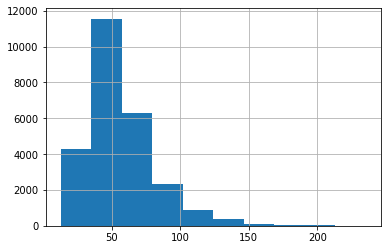

In [32]:
pd.Series(stat_train['len']).hist()

<AxesSubplot:>

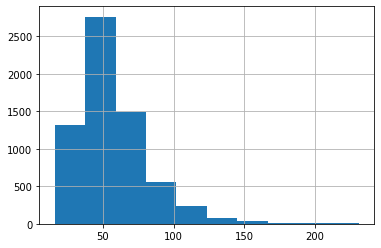

In [33]:
pd.Series(stat_dev['len']).hist()

<AxesSubplot:>

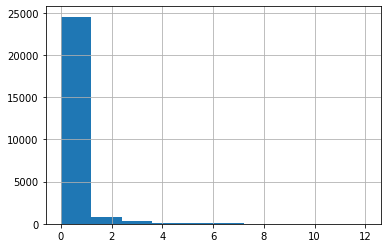

In [34]:
pd.Series(stat_train['n_unk']).hist()

<AxesSubplot:>

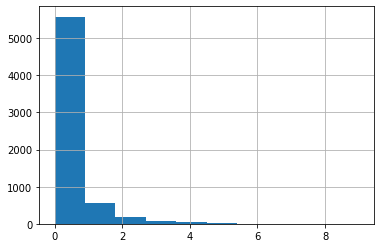

In [235]:
pd.Series(stat_dev['n_unk']).hist()